In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns
import sklearn

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import OLSInfluence

from scipy.stats import spearmanr, pearsonr

In [51]:
# Load the merged data from the CSV file
csv_file_path = 'D:/OneDrive - University College London/Desktop/merge_data_new.csv'
df = pd.read_csv(csv_file_path)


In [52]:
df.head()

,Ward,Old Ward Code,Local Authority,ward_name,Geography,2010-14;Male;Life expectancy at birth,2010-14;Female;Life expectancy at birth,Median monthly houshold income,Employment rate 2011 (16-64),well-being scores,percent_green,access_to_open_space
0,E05000026,00ABFX,Barking and Dagenham,Abbey,Ward,80.0,83.6,33920,60.3,7.789197,27.838313,70.70
1,E05000026,00ABFX,Barking and Dagenham,Abbey,Ward,80.0,83.6,33920,60.3,7.789197,27.838313,75.56
2,E05000026,00ABFX,Barking and Dagenham,Abbey,Ward,80.0,83.6,33920,60.3,7.789197,25.961439,70.70
3,E05000026,00ABFX,Barking and Dagenham,Abbey,Ward,80.0,83.6,33920,60.3,7.789197,25.961439,75.56
4,E05000027,00ABFY,Barking and Dagenham,Alibon,Ward,77.0,81.4,32470,63.1,7.553030,45.937133,8.01


rename the columns

In [53]:
new_column_names = {
    "2010-14;Male;Life expectancy at birth": "Life Expectancy (Male)",
    "2010-14;Female;Life expectancy at birth": "Life Expectancy (Female)",
    "Median monthly houshold income": "Household Income",
    "well-being scores": "Well-being",
    "percent_green": "Green Space",
    "access_to_open_space": "Open Space Accessibility",
    "Employment rate 2011 (16-64)":"Employment Rate",
    "ward_name" : "Ward Name",
}

df.rename(columns=new_column_names, inplace=True)

print(df.columns)

Index(['Ward', 'Old Ward Code', 'Local Authority', 'Ward Name', 'Geography',
       'Life Expectancy (Male)', 'Life Expectancy (Female)',
       'Household Income', 'Employment Rate', 'Well-being', 'Green Space',
       'Open Space Accessibility'],
      dtype='object')


remove n/a

In [54]:
# Drop rows with missing values
df = df.dropna(subset=['Household Income', 'Employment Rate', 'Well-being', 'Green Space', 'Open Space Accessibility', 'Life Expectancy (Male)'])

In [55]:
# Describe the numerical columns
description = df.describe()
description

,Life Expectancy (Male),Life Expectancy (Female),Household Income,Employment Rate,Well-being,Green Space,Open Space Accessibility
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,80.304739,84.521011,39488.783570,69.862559,7.639812,42.082352,48.833460
std,2.513289,2.354248,7712.542797,6.194605,0.214728,15.741666,26.916148
min,74.300000,77.700000,25090.000000,48.700000,7.155185,1.588666,0.000000
25%,78.700000,82.900000,33890.000000,65.600000,7.478364,30.724412,27.980000
50%,80.100000,84.400000,38130.000000,70.400000,7.643298,41.699136,49.140000
75%,82.000000,86.100000,43800.000000,74.500000,7.770077,51.896926,70.700000
max,91.000000,93.100000,88330.000000,83.900000,8.423186,91.337776,100.000000


EDA

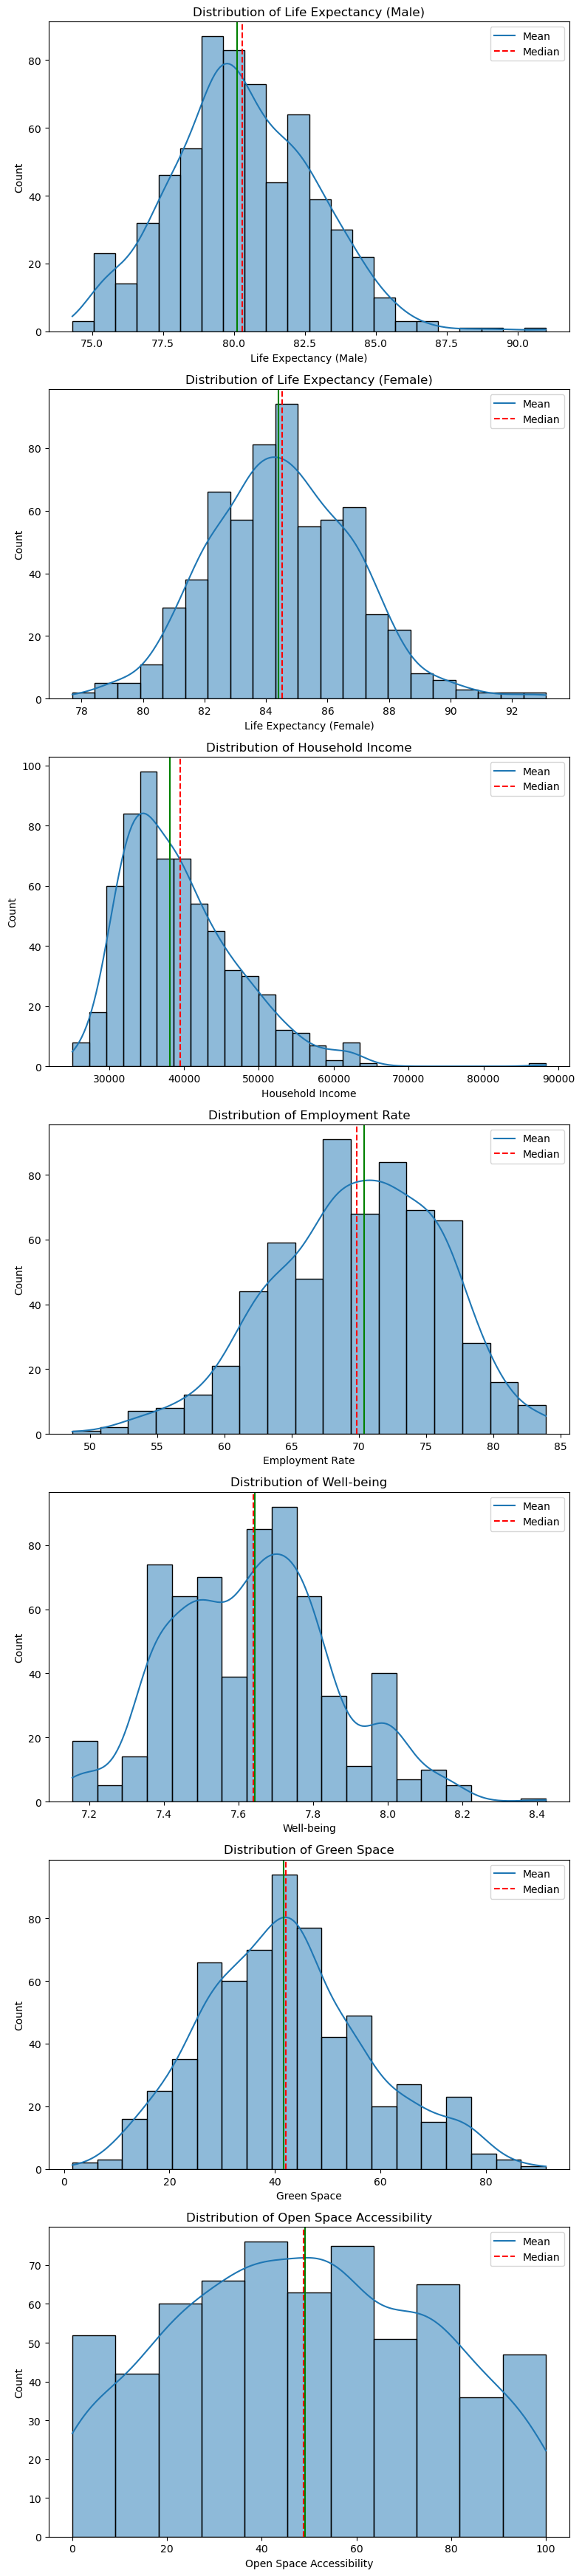

In [56]:

# plot the distributions of the numerical columns
# use histograms for the distribution
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 5 * len(num_cols)))

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    mean = df[col].mean()
    median = df[col].median()
    axes[i].axvline(mean, color='r', linestyle='--')
    axes[i].axvline(median, color='g', linestyle='-')
    axes[i].legend({'Mean':mean,'Median':median})
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()





calculate p-values of the D’Agostino and Pearson’s test

In [57]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    _, p_val = stats.normaltest(df[col])
    print(f'p-value for {col}: {p_val}')

p-value for Life Expectancy (Male): 0.014632188742934085
p-value for Life Expectancy (Female): 0.01598714272866464
p-value for Household Income: 6.380719839472031e-31
p-value for Employment Rate: 0.0028397635511949178
p-value for Well-being: 0.05358722661068752
p-value for Green Space: 0.0016007008436404015
p-value for Open Space Accessibility: 3.9157929862566585e-20


Shapiro—Wilk test

In [58]:
for col in num_cols:
    _, p_val = stats.shapiro(df[col])
    print(f'p-value for {col}: {p_val}')

p-value for Life Expectancy (Male): 0.0027329165022820234
p-value for Life Expectancy (Female): 0.02358037233352661
p-value for Household Income: 1.5171091974730506e-16
p-value for Employment Rate: 0.00038279136060737073
p-value for Well-being: 1.7068534361897036e-05
p-value for Green Space: 3.3325584809063e-05
p-value for Open Space Accessibility: 5.4878270816516306e-09


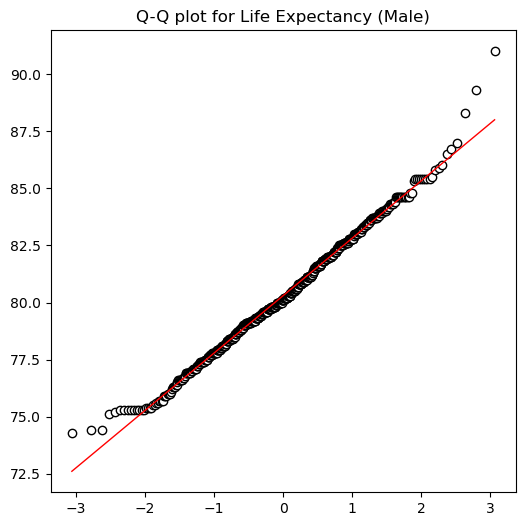

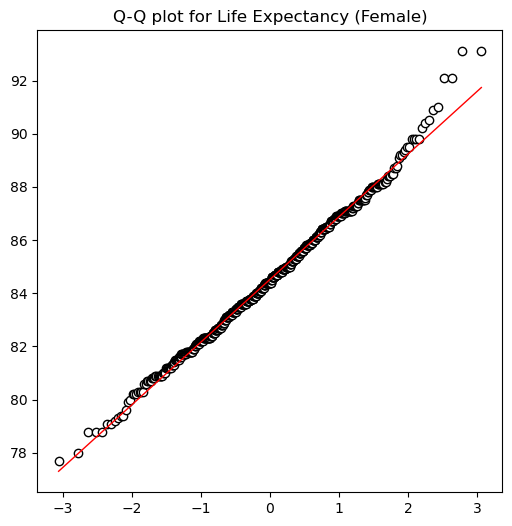

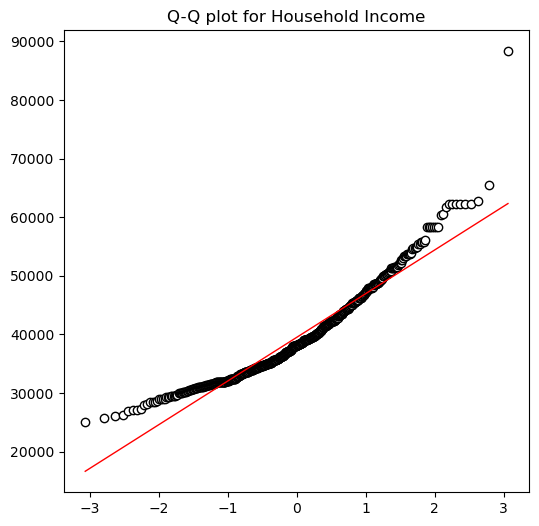

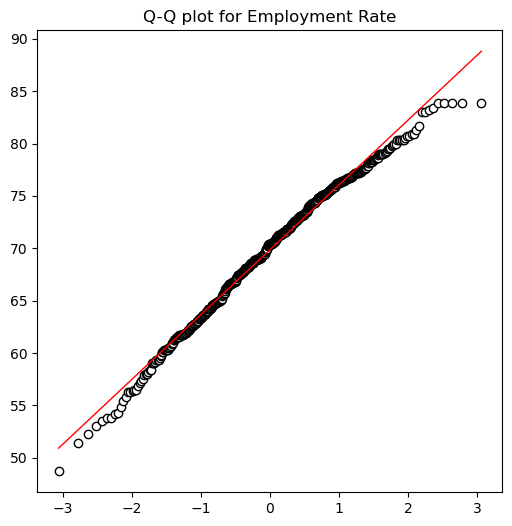

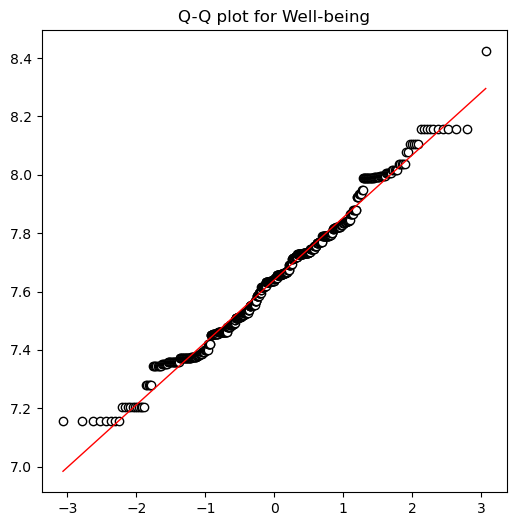

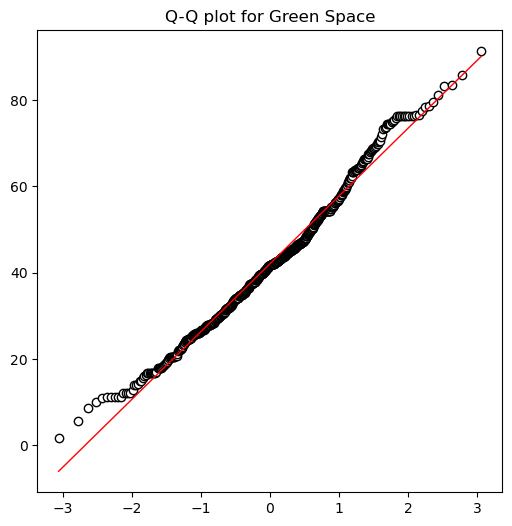

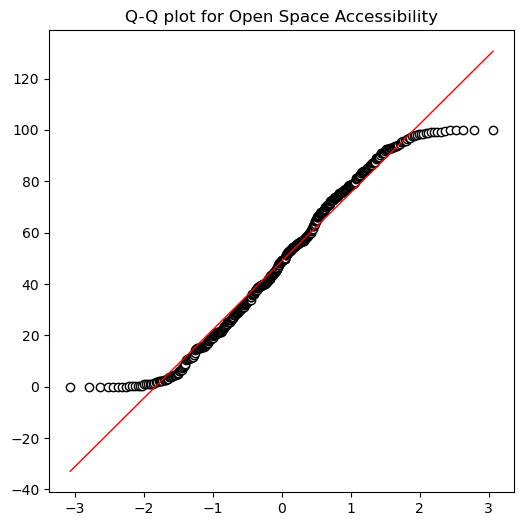

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

num_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    plt.figure(figsize=(6, 6))
    (osm, osr), (slope, intercept, r) = stats.probplot(df[col], dist="norm", plot=None)
    plt.plot(osm, osr, 'o', markerfacecolor='w', markeredgecolor='k')
    plt.plot(osm, intercept + slope * osm, 'r', lw=1)
    plt.title(f'Q-Q plot for {col}')
    plt.show()
    

q-q plot

correlation matrix

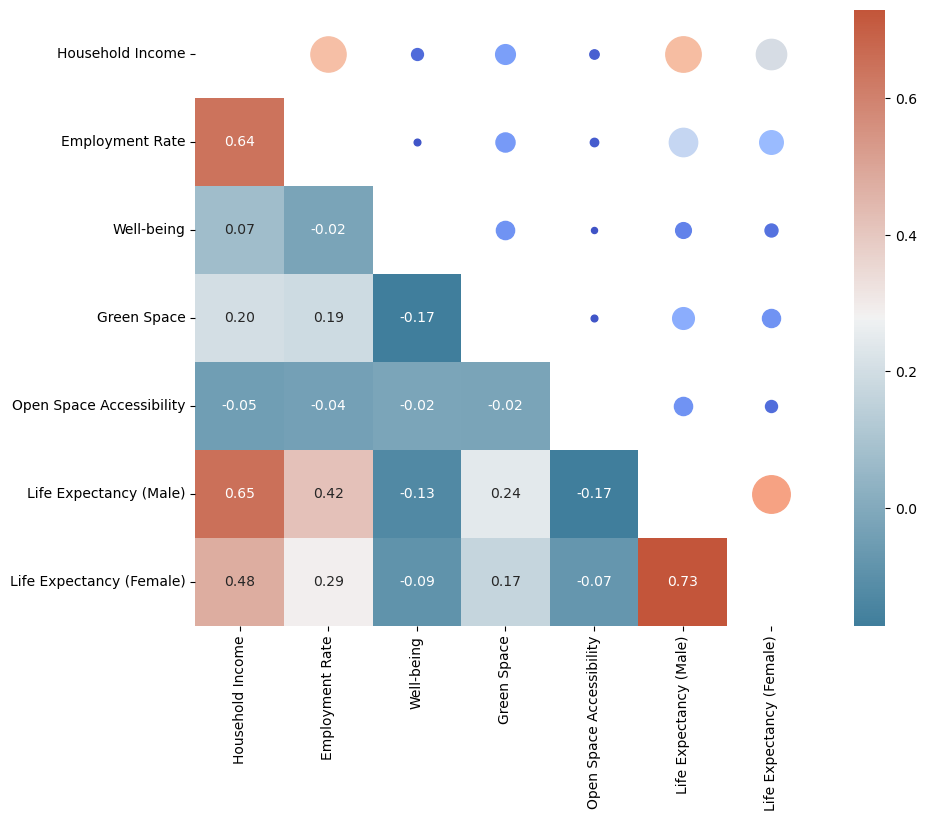

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Calculate the correlation matrix
corr = df[['Household Income', 'Employment Rate', 'Well-being', 'Green Space', 'Open Space Accessibility', 'Life Expectancy (Male)', 'Life Expectancy (Female)']].corr()

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with 'sns.heatmap()'
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f")

# Add circles with size and color proportional to the absolute correlation
for i in range(len(corr.columns)):
    for j in range(i):
        if not mask[i, j]:
            value = np.abs(corr.iloc[i, j])
            size = value * 1000  # Set the size based on the absolute correlation
            color = value  # Set the color based on the absolute correlation
            plt.scatter(i + 0.5, j + 0.5, s=size, c=color, cmap='coolwarm', marker='o', vmin=0, vmax=1)

plt.show()


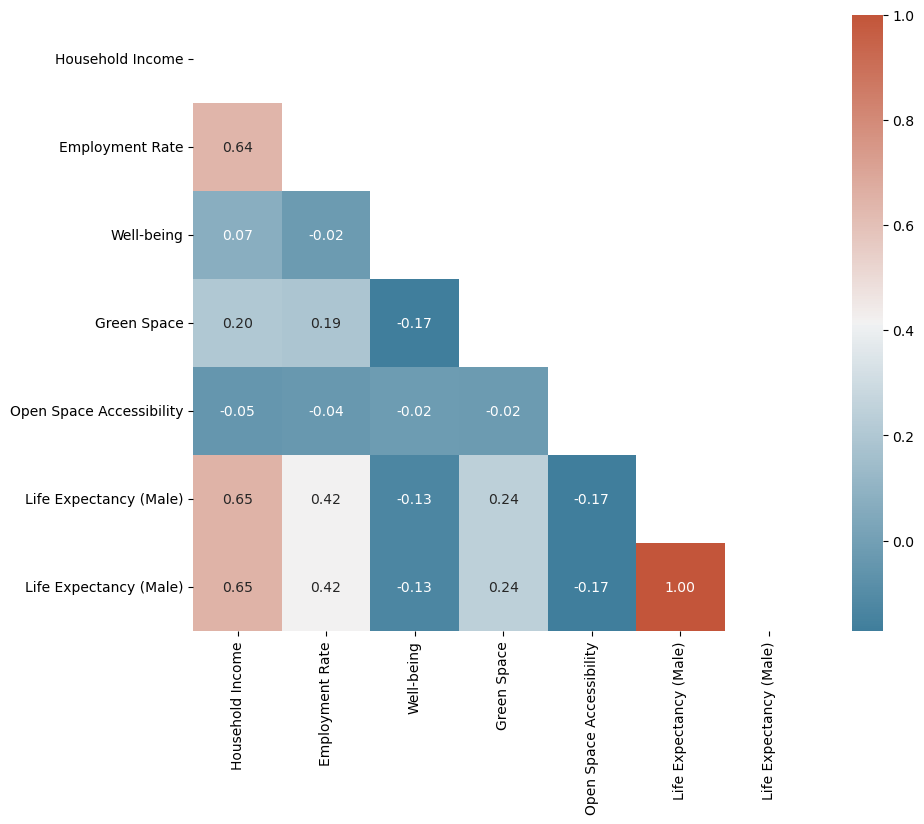

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the correlation matrix
corr = df[['Household Income', 'Employment Rate', 'Well-being', 'Green Space', 'Open Space Accessibility',"Life Expectancy (Male)","Life Expectancy (Male)"]].corr()

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with 'sns.heatmap()'
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f")

plt.show()

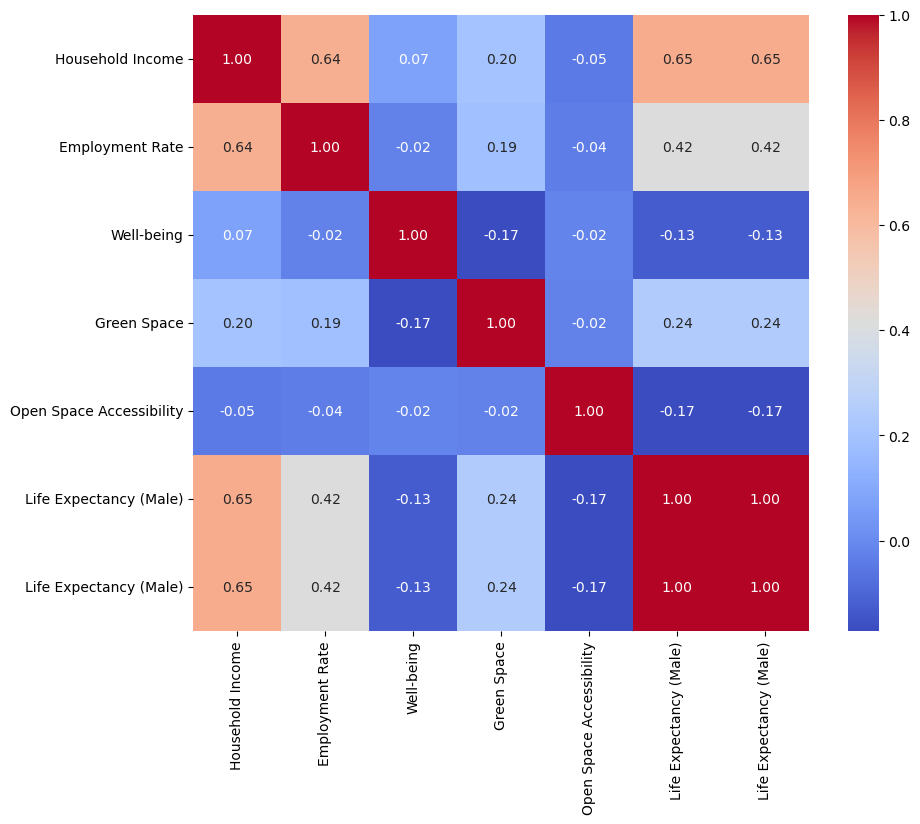

In [62]:
# Calculate the correlation matrix
corr = df[['Household Income', 'Employment Rate', 'Well-being', 'Green Space', 'Open Space Accessibility',"Life Expectancy (Male)","Life Expectancy (Male)"]].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.show()

test the multicollinearity of the independent variables

In [63]:
# Define the independent variables
X = df[['Household Income', 'Employment Rate', 'Well-being', 'Green Space', 'Open Space Accessibility']]

# Add a constant to the independent variables
X = sm.add_constant(X)

# Calculate the VIF for each independent variable
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                  variables          VIF
0                     const  1531.879237
1          Household Income     1.756320
2           Employment Rate     1.725041
3                Well-being     1.050172
4               Green Space     1.086303
5  Open Space Accessibility     1.002750


simple linear regression

Regression results for Household Income:

                              OLS Regression Results                              
Dep. Variable:     Life Expectancy (Male)   R-squared:                       0.421
Model:                                OLS   Adj. R-squared:                  0.420
Method:                     Least Squares   F-statistic:                     459.4
Date:                    Sun, 10 Dec 2023   Prob (F-statistic):           5.49e-77
Time:                            13:04:15   Log-Likelihood:                -1307.9
No. Observations:                     633   AIC:                             2620.
Df Residuals:                         631   BIC:                             2629.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

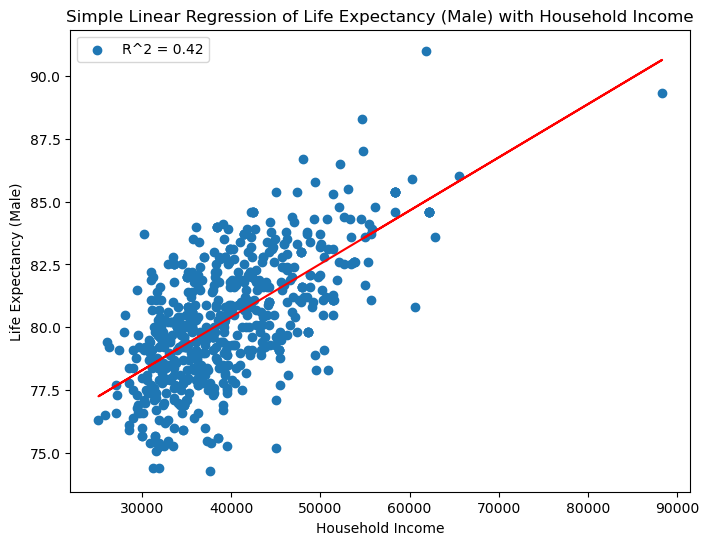

Regression results for Employment Rate:

                              OLS Regression Results                              
Dep. Variable:     Life Expectancy (Male)   R-squared:                       0.173
Model:                                OLS   Adj. R-squared:                  0.172
Method:                     Least Squares   F-statistic:                     132.4
Date:                    Sun, 10 Dec 2023   Prob (F-statistic):           6.06e-28
Time:                            13:04:15   Log-Likelihood:                -1420.8
No. Observations:                     633   AIC:                             2846.
Df Residuals:                         631   BIC:                             2854.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

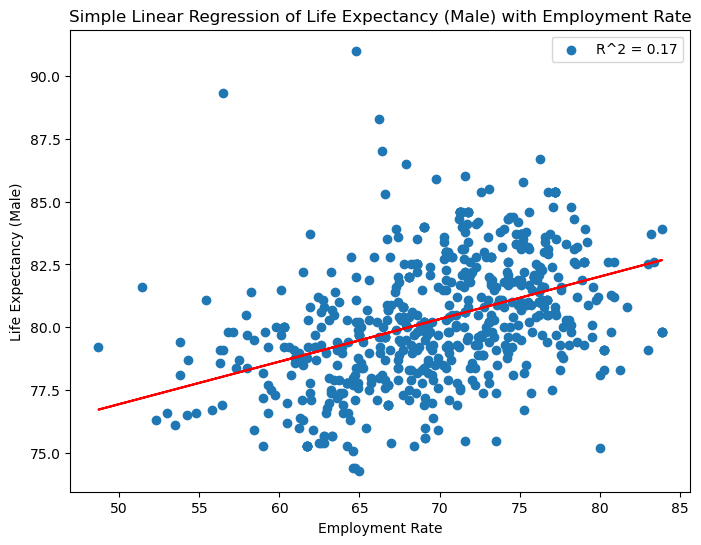

Regression results for Well-being:

                              OLS Regression Results                              
Dep. Variable:     Life Expectancy (Male)   R-squared:                       0.017
Model:                                OLS   Adj. R-squared:                  0.015
Method:                     Least Squares   F-statistic:                     10.59
Date:                    Sun, 10 Dec 2023   Prob (F-statistic):            0.00120
Time:                            13:04:15   Log-Likelihood:                -1475.8
No. Observations:                     633   AIC:                             2956.
Df Residuals:                         631   BIC:                             2964.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

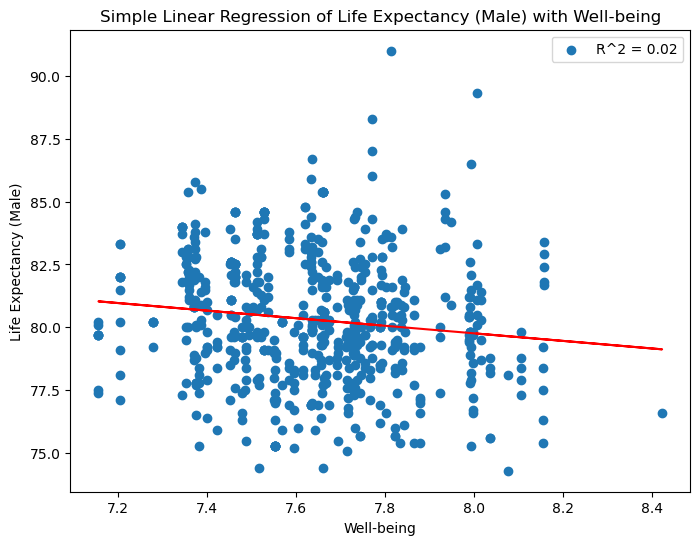

Regression results for Green Space:

                              OLS Regression Results                              
Dep. Variable:     Life Expectancy (Male)   R-squared:                       0.059
Model:                                OLS   Adj. R-squared:                  0.058
Method:                     Least Squares   F-statistic:                     39.87
Date:                    Sun, 10 Dec 2023   Prob (F-statistic):           5.13e-10
Time:                            13:04:15   Log-Likelihood:                -1461.7
No. Observations:                     633   AIC:                             2927.
Df Residuals:                         631   BIC:                             2936.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

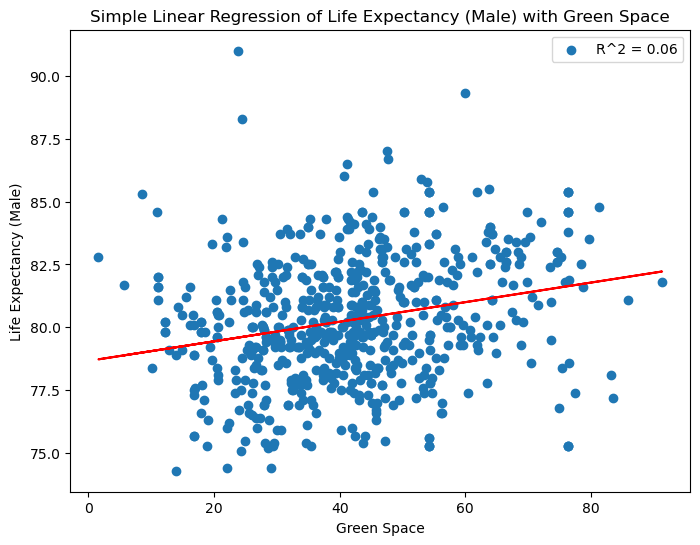

Regression results for Open Space Accessibility:

                              OLS Regression Results                              
Dep. Variable:     Life Expectancy (Male)   R-squared:                       0.029
Model:                                OLS   Adj. R-squared:                  0.028
Method:                     Least Squares   F-statistic:                     18.93
Date:                    Sun, 10 Dec 2023   Prob (F-statistic):           1.58e-05
Time:                            13:04:16   Log-Likelihood:                -1471.7
No. Observations:                     633   AIC:                             2947.
Df Residuals:                         631   BIC:                             2956.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

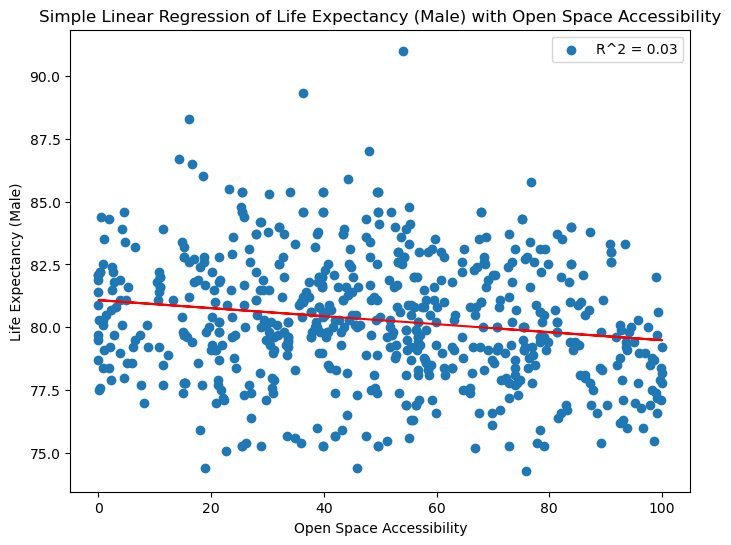

In [64]:
# List of independent variables
variables = ['Household Income', 'Employment Rate', 'Well-being', 'Green Space', 'Open Space Accessibility']

# Perform a simple linear regression for each variable
for var in variables:
    X = sm.add_constant(df[var])
    y = df['Life Expectancy (Male)']
    model = sm.OLS(y, X)
    results = model.fit()
    print(f"Regression results for {var}:\n")
    print(results.summary())
    print("\n---------------------------------\n")

    # Plot the regression line and the data points
    plt.figure(figsize=(8, 6))
    plt.scatter(df[var], y)
    plt.plot(df[var], results.predict(X), color='red')
    plt.xlabel(var)
    plt.ylabel('Life Expectancy (Male)')
    plt.title(f'Simple Linear Regression of Life Expectancy (Male) with {var}')
    r_squared = results.rsquared
    plt.legend([f'R^2 = {r_squared:.2f}'])
    plt.show()

Regression results for Household Income:

                               OLS Regression Results                               
Dep. Variable:     Life Expectancy (Female)   R-squared:                       0.226
Model:                                  OLS   Adj. R-squared:                  0.225
Method:                       Least Squares   F-statistic:                     184.8
Date:                      Sun, 10 Dec 2023   Prob (F-statistic):           4.28e-37
Time:                              13:04:16   Log-Likelihood:                -1358.4
No. Observations:                       633   AIC:                             2721.
Df Residuals:                           631   BIC:                             2730.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

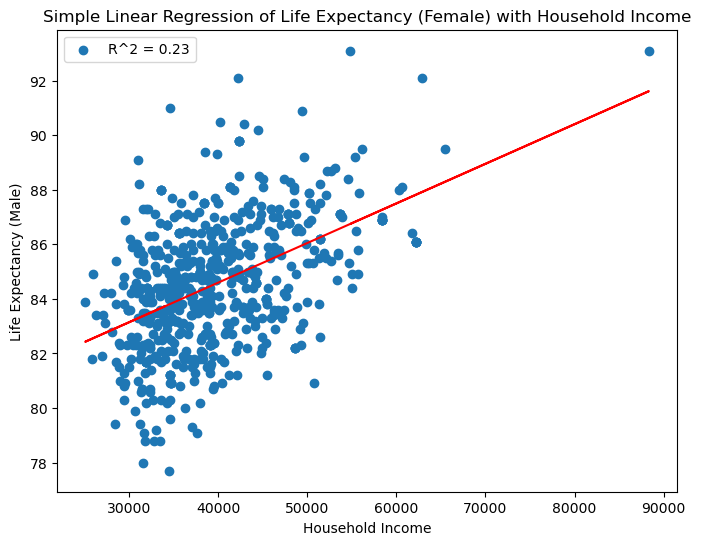

Regression results for Employment Rate:

                               OLS Regression Results                               
Dep. Variable:     Life Expectancy (Female)   R-squared:                       0.083
Model:                                  OLS   Adj. R-squared:                  0.081
Method:                       Least Squares   F-statistic:                     56.94
Date:                      Sun, 10 Dec 2023   Prob (F-statistic):           1.58e-13
Time:                              13:04:16   Log-Likelihood:                -1412.3
No. Observations:                       633   AIC:                             2829.
Df Residuals:                           631   BIC:                             2838.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

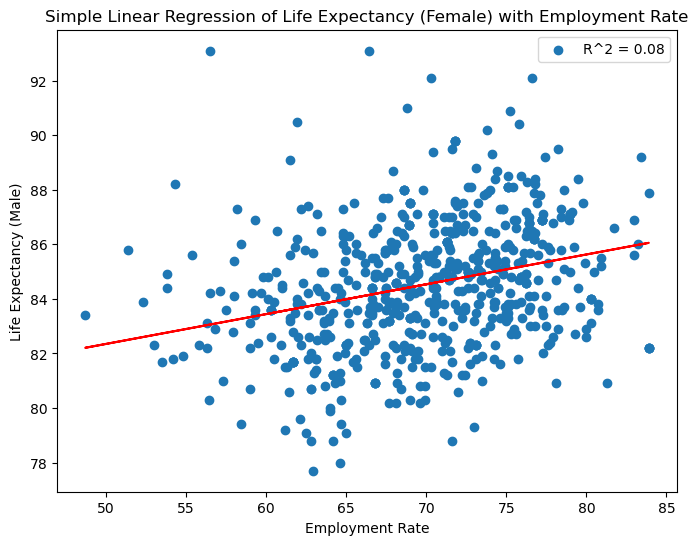

Regression results for Well-being:

                               OLS Regression Results                               
Dep. Variable:     Life Expectancy (Female)   R-squared:                       0.008
Model:                                  OLS   Adj. R-squared:                  0.006
Method:                       Least Squares   F-statistic:                     4.831
Date:                      Sun, 10 Dec 2023   Prob (F-statistic):             0.0283
Time:                              13:04:16   Log-Likelihood:                -1437.3
No. Observations:                       633   AIC:                             2879.
Df Residuals:                           631   BIC:                             2887.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

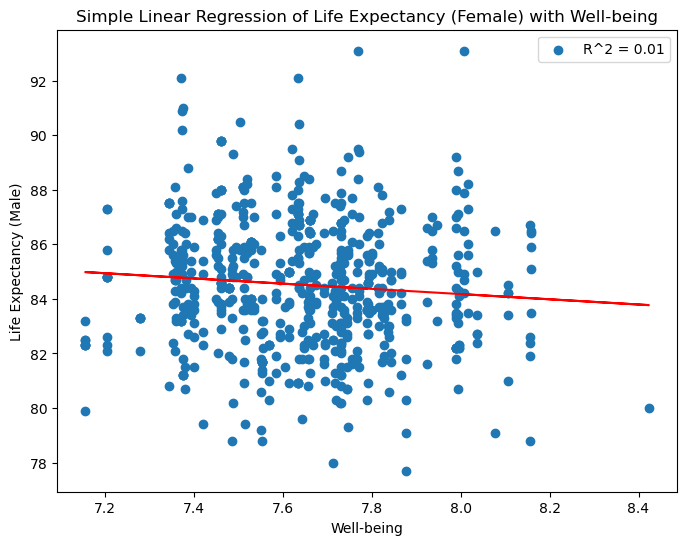

Regression results for Green Space:

                               OLS Regression Results                               
Dep. Variable:     Life Expectancy (Female)   R-squared:                       0.029
Model:                                  OLS   Adj. R-squared:                  0.027
Method:                       Least Squares   F-statistic:                     18.57
Date:                      Sun, 10 Dec 2023   Prob (F-statistic):           1.90e-05
Time:                              13:04:16   Log-Likelihood:                -1430.5
No. Observations:                       633   AIC:                             2865.
Df Residuals:                           631   BIC:                             2874.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

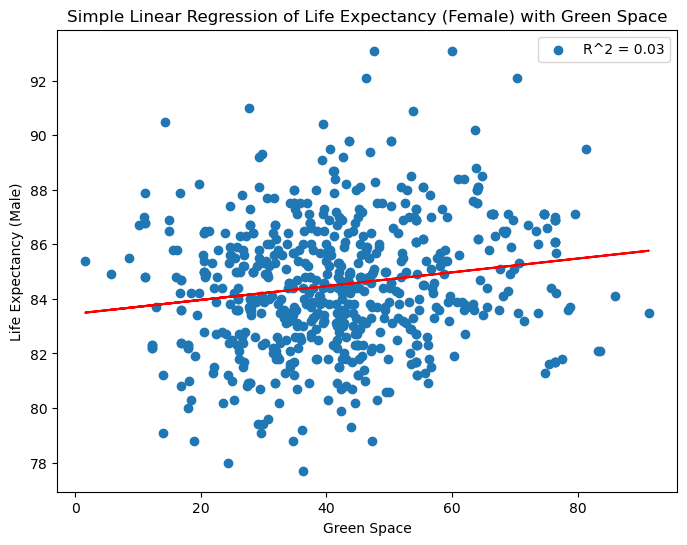

Regression results for Open Space Accessibility:

                               OLS Regression Results                               
Dep. Variable:     Life Expectancy (Female)   R-squared:                       0.006
Model:                                  OLS   Adj. R-squared:                  0.004
Method:                       Least Squares   F-statistic:                     3.520
Date:                      Sun, 10 Dec 2023   Prob (F-statistic):             0.0611
Time:                              13:04:17   Log-Likelihood:                -1437.9
No. Observations:                       633   AIC:                             2880.
Df Residuals:                           631   BIC:                             2889.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------

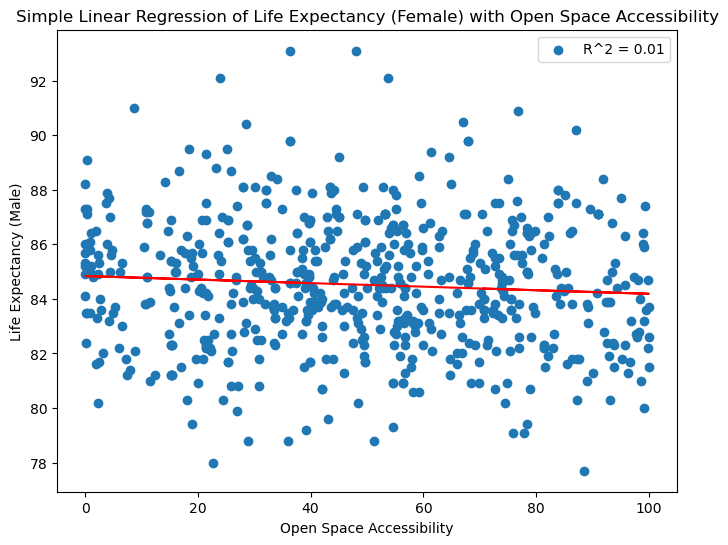

In [65]:
# List of independent variables
variables = ['Household Income', 'Employment Rate', 'Well-being', 'Green Space', 'Open Space Accessibility']

# Perform a simple linear regression for each variable
for var in variables:
    X = sm.add_constant(df[var])
    y = df['Life Expectancy (Female)']
    model = sm.OLS(y, X)
    results = model.fit()
    print(f"Regression results for {var}:\n")
    print(results.summary())
    print("\n---------------------------------\n")

    # Plot the regression line and the data points
    plt.figure(figsize=(8, 6))
    plt.scatter(df[var], y)
    plt.plot(df[var], results.predict(X), color='red')
    plt.xlabel(var)
    plt.ylabel('Life Expectancy (Male)')
    plt.title(f'Simple Linear Regression of Life Expectancy (Female) with {var}')
    r_squared = results.rsquared
    plt.legend([f'R^2 = {r_squared:.2f}'])
    plt.show()

multi regression

In [66]:
# Define the independent variables
X = df[['Household Income', 'Employment Rate', 'Well-being', 'Green Space', 'Open Space Accessibility']]

# Add a constant to the independent variables
X = sm.add_constant(X)

# Define the dependent variable
y = df['Life Expectancy (Male)']

# Perform the regression
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     Life Expectancy (Male)   R-squared:                       0.480
Model:                                OLS   Adj. R-squared:                  0.476
Method:                     Least Squares   F-statistic:                     115.9
Date:                    Sun, 10 Dec 2023   Prob (F-statistic):           1.12e-86
Time:                            13:04:17   Log-Likelihood:                -1273.9
No. Observations:                     633   AIC:                             2560.
Df Residuals:                         627   BIC:                             2587.
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

The variable with the strongest explanation for 'Life Expectancy (Male)' is: Well-being

In [80]:
# Perform the regression as before
X = df[['Household Income', 'Employment Rate', 'Well-being', 'Green Space', 'Open Space Accessibility']]
X = sm.add_constant(X)
y = df['Life Expectancy (Female)']
model = sm.OLS(y, X)
results = model.fit()

# Get the coefficients
coefficients = results.params

# Remove the constant
coefficients = coefficients.drop('const')

# Get the variable with the strongest explanation
strongest_variable = coefficients.abs().idxmax()

print(f"The variable with the strongest explanation for 'Life Expectancy (Female)' is: {strongest_variable}")

The variable with the strongest explanation for 'Life Expectancy (Female)' is: Well-being


In [68]:
y = df['Life Expectancy (Female)']

# Perform the regression
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     Life Expectancy (Female)   R-squared:                       0.249
Model:                                  OLS   Adj. R-squared:                  0.243
Method:                       Least Squares   F-statistic:                     41.49
Date:                      Sun, 10 Dec 2023   Prob (F-statistic):           6.38e-37
Time:                              13:04:17   Log-Likelihood:                -1349.2
No. Observations:                       633   AIC:                             2710.
Df Residuals:                           627   BIC:                             2737.
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

The variable with the strongest explanation for 'Life Expectancy (Female)' is: Well-being

### residual analysis

autocorrelation of residuals (Durbin-Watson test)

In [69]:
from statsmodels.stats.stattools import durbin_watson

# Calculate the residuals
residuals = results.resid

# Perform the Durbin-Watson test
dw_result = durbin_watson(residuals)

print(f"Durbin-Watson test statistic: {dw_result}")

Durbin-Watson test statistic: 1.5344109790793097


The `durbin_watson` function returns a test statistic, with values ranging from 0 to 4. A value of 2 means there is no autocorrelation in the sample. Values from 0 to less than 2 indicate positive autocorrelation, and values from more than 2 to 4 indicate negative autocorrelation.

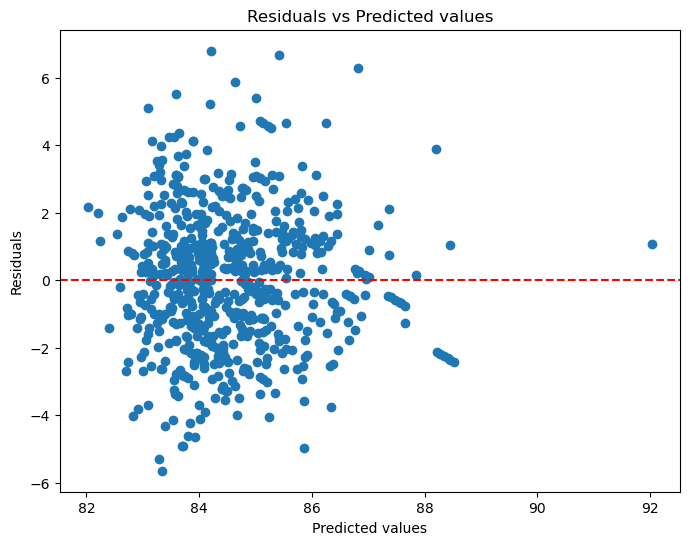

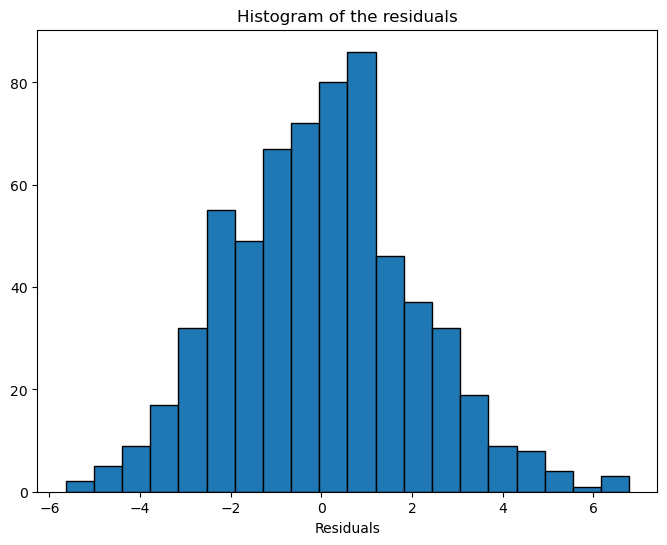

In [70]:
# Calculate the residuals
residuals = results.resid

# Create a scatter plot of the predicted values and residuals
plt.figure(figsize=(8, 6))
plt.scatter(results.predict(), residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()

# Create a histogram of the residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Residuals')
plt.title('Histogram of the residuals')
plt.show()



normality of residuals

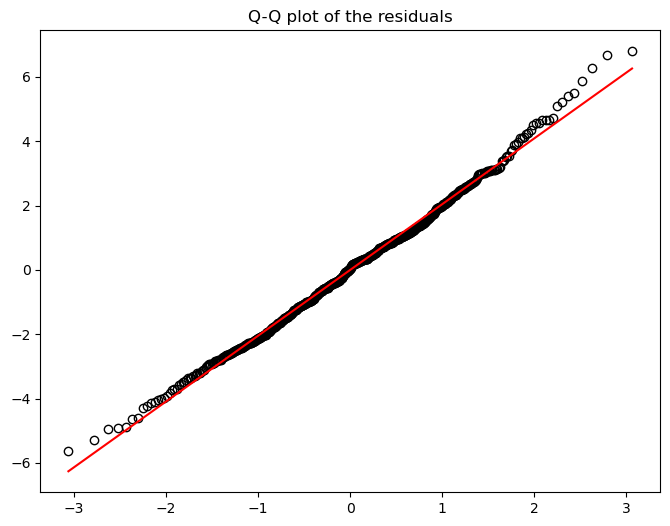

In [77]:
import matplotlib.pyplot as plt
from scipy import stats

# Create a Q-Q plot of the residuals
plt.figure(figsize=(8, 6))
(osm, osr), (slope, intercept, r) = stats.probplot(residuals, plot=None)
plt.plot(osm, osr, 'o', markerfacecolor='none', markeredgecolor='black')
plt.plot(osm, slope*osm + intercept, 'r')  # Add trend line
plt.title('Q-Q plot of the residuals')
plt.show()

Cook's distance: 0      8.134872e-06
1      1.129555e-05
2      1.009312e-05
3      1.368330e-05
4      2.035338e-03
           ...     
716    1.980856e-04
717    8.315284e-07
718    4.300068e-03
719    2.467191e-03
720    1.534787e-03
Length: 633, dtype: float64
Mean of Cook's distance: 0.0015360731536343236
Outliers: [ 15  58  67  71  72  80 120 126 144 178 185 199 208 215 232 240 246 280
 282 287 293 299 324 350 359 360 383 422 435 462 464 465 466 467 471 474
 480 481 484 486 490 566 567 569 595 596 597 598 605 610 612 622]


KeyError: '[58, 144, 246, 465, 566, 595] not in index'

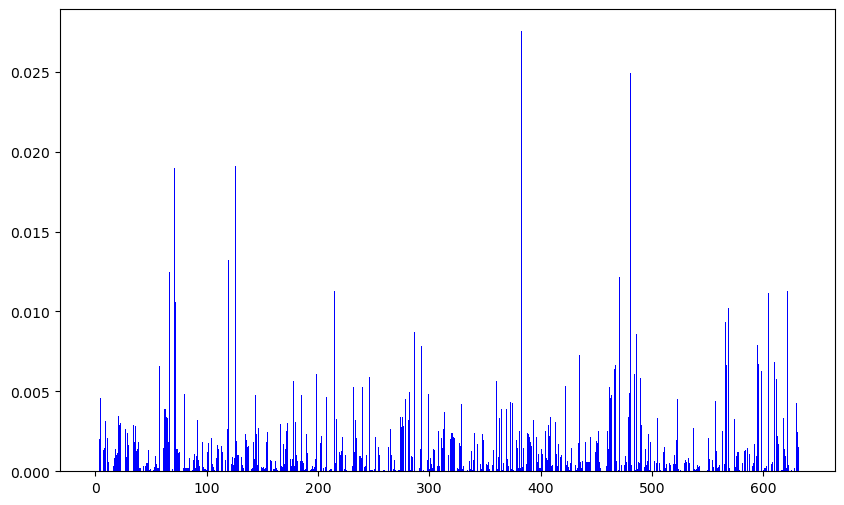

In [72]:
# Calculate Cook's distance
influence = OLSInfluence(results)
cooks_d = influence.cooks_distance[0]

# Calculate the mean of Cook's distance
mean_cooks_d = np.mean(cooks_d)

# Identify outliers
outliers = np.where(cooks_d > mean_cooks_d * 3)[0]

print(f"Cook's distance: {cooks_d}")
print(f"Mean of Cook's distance: {mean_cooks_d}")
print(f"Outliers: {outliers}")



# Create a bar plot of Cook's distance
plt.figure(figsize=(10, 6))
plt.bar(range(len(cooks_d)), cooks_d, color='blue')

# Highlight the outliers in red
plt.bar(outliers, cooks_d[outliers], color='red')

plt.xlabel('Observation index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot")
plt.show()

KeyError: '[58, 144, 246, 465, 566, 595] not in index'

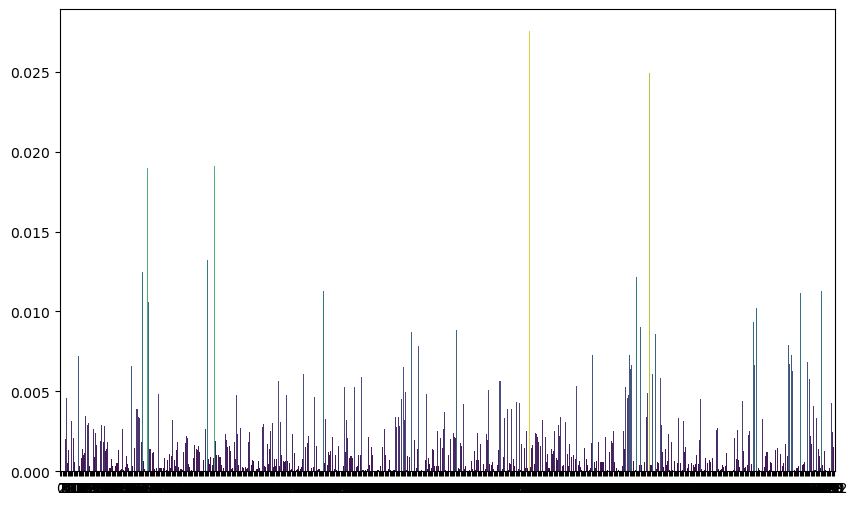

In [78]:
import seaborn as sns

# Create a bar plot of Cook's distance
plt.figure(figsize=(10, 6))

# Create a color map
colors = plt.cm.viridis(cooks_d / max(cooks_d))

# Create a bar plot with colors based on Cook's distance
sns.barplot(x=np.arange(len(cooks_d)), y=cooks_d, palette=colors)

# Highlight the outliers in red
plt.bar(outliers, cooks_d[outliers], color='red')

plt.xlabel('Observation index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot")
plt.show()

The figure shows that every point has a value of less than 1, indicating acceptable values.